# Global Invoicing: Processing Data

In [1]:
import pandas as pd
import numpy as np
import os

## Import Data

In [2]:
import pyodbc
import os
import dotenv

dotenv.load_dotenv()

server = os.getenv("PROPHET_SERVER")
database = os.getenv("PROPHET_DATABASE")
username = os.getenv("PROPHET_USERNAME")
password = os.getenv("PROPHET_PASSWORD")
driver = '{ODBC Driver 17 for SQL Server}'

start_date = '2021-01-01'
end_date = '2021-09-01'

cnxn = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}')
cursor = cnxn.cursor()

In [3]:
raw_data_path = os.path.join(os.path.pardir, 'data', 'raw')
orders_file_path = os.path.join(raw_data_path, 'orders.csv')
finished_file_path = os.path.join(raw_data_path, 'finished.csv')
ingredients_file_path = os.path.join(raw_data_path, 'ingredients.csv')
packaging_file_path = os.path.join(raw_data_path, 'packaging.csv')
resources_file_path = os.path.join(raw_data_path, 'resources.csv')
waste_file_path = os.path.join(raw_data_path, 'waste.csv')

df = pd.read_csv(orders_file_path, index_col='palordid')
finished_df = pd.read_csv(finished_file_path, index_col='palstkid')
ingredients_df = pd.read_csv(ingredients_file_path, index_col='palstkid')
packaging_df = pd.read_csv(packaging_file_path, index_col='palstkid')
resources_df = pd.read_csv(resources_file_path, index_col='rescode')
waste_df = pd.read_csv(waste_file_path)


## Basic Structure

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60094 entries, 2417225 to 2922075
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   palstkid       60094 non-null  int64  
 1   qty            60094 non-null  int64  
 2   orddetid       60094 non-null  int64  
 3   ponum          60093 non-null  float64
 4   ordnum         60094 non-null  int64  
 5   delcustcode    60094 non-null  object 
 6   deldate        60094 non-null  object 
 7   name           60094 non-null  object 
 8   prodnum        60093 non-null  float64
 9   jobnum         60083 non-null  float64
 10  mark           60094 non-null  object 
 11  descr          60094 non-null  object 
 12  countsize      60094 non-null  object 
 13  uomtradingqty  60094 non-null  float64
 14  sodusseldorfs  58681 non-null  float64
dtypes: float64(5), int64(4), object(6)
memory usage: 7.3+ MB


In [5]:
df.head(100)

,palstkid,qty,orddetid,ponum,ordnum,delcustcode,deldate,name,prodnum,jobnum,mark,descr,countsize,uomtradingqty,sodusseldorfs
palordid,,,,,,,,,,,,,,,
2417225,1497321,60,1393318,64117.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2000866.0,112869.0,GP ALDI,Easy Peeler,22x500g,113.0,6.0
2417340,1496082,40,1393334,62762.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001175.0,112746.0,GP ALDI,Pears,10x750g,113.0,6.0
2416814,1494310,48,1401546,64073.0,77374,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001186.0,112631.0,GP ALDI,Easy Peeler,10x750g EP,238.0,9.0
2417357,1494270,30,1393324,64100.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001230.0,112707.0,GP ALDI,Orange,10x4-Pack,110.0,6.0
2417384,1495900,88,1393339,63773.0,76950,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2000623.0,112730.0,GP ALDI,Black Grape,10x500g,128.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416808,1496970,40,1401544,64097.0,77374,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2000937.0,112847.0,GP ALDI,Orange,8X1.5KG,443.0,22.0
2417348,1494085,25,1393331,63075.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001099.0,112592.0,GP ALDI,Apple,14x5-Pack,126.0,6.0
2417451,1494141,44,1401541,63492.0,77372,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001173.0,112596.0,GP ALDI,Pears,10x1kg,221.0,10.0


In [6]:
df.describe()

,palstkid,qty,orddetid,ponum,ordnum,prodnum,jobnum,uomtradingqty,sodusseldorfs
count,6.009400e+04,60094.000000,6.009400e+04,60093.000000,60094.000000,6.009300e+04,60083.000000,60094.000000,58681.000000
mean,1.635084e+06,33.880637,1.556656e+06,70051.850116,85040.708790,2.001063e+06,127067.926335,263.584651,10.128849
std,7.945483e+04,24.836144,9.127725e+04,3945.935070,4525.569221,7.733485e+02,8685.785743,389.217109,13.967545
min,0.000000e+00,1.000000,1.383131e+06,61396.000000,76944.000000,2.000338e+06,111224.000000,1.000000,0.000000
25%,1.568143e+06,13.000000,1.477978e+06,66768.000000,81117.000000,2.000865e+06,119562.000000,53.000000,2.000000
50%,1.634002e+06,34.000000,1.552950e+06,69473.000000,84460.000000,2.001102e+06,126237.000000,123.000000,5.000000
75%,1.703515e+06,44.000000,1.635242e+06,73691.000000,89191.000000,2.001174e+06,134783.000000,241.000000,9.000000
max,1.776478e+06,201.000000,1.716982e+06,77559.000000,92651.000000,2.009971e+06,142310.000000,2934.000000,66.000000


In [7]:
df.qty.describe()

count    60094.000000
mean        33.880637
std         24.836144
min          1.000000
25%         13.000000
50%         34.000000
75%         44.000000
max        201.000000
Name: qty, dtype: float64

<AxesSubplot:>

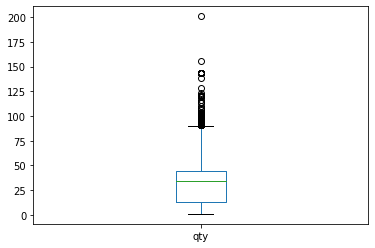

In [8]:
df.qty.plot(kind='box')

In [9]:
df.descr.value_counts()

Apple               20487
Pears                7804
Easy Peeler          4071
Red Grape            4048
Orange               3734
Mixed Grape          2958
Blueberries          2693
Kiwi                 2233
Nectarines           1906
Green Grape          1851
Limes                1462
Black Grape          1451
Plums                1031
Peaches               788
Grapefruit            704
Donut Peaches         618
Lemons                562
Apricot               523
Lemon & Lime          402
Ginger                264
Flat Nectarine        151
Speciality Grape      149
Organic Grapes        106
Tri-Pack Grapes        98
Name: descr, dtype: int64

In [10]:
df.descr.value_counts(normalize=True)

Apple               0.340916
Pears               0.129863
Easy Peeler         0.067744
Red Grape           0.067361
Orange              0.062136
Mixed Grape         0.049223
Blueberries         0.044813
Kiwi                0.037158
Nectarines          0.031717
Green Grape         0.030802
Limes               0.024329
Black Grape         0.024146
Plums               0.017156
Peaches             0.013113
Grapefruit          0.011715
Donut Peaches       0.010284
Lemons              0.009352
Apricot             0.008703
Lemon & Lime        0.006690
Ginger              0.004393
Flat Nectarine      0.002513
Speciality Grape    0.002479
Organic Grapes      0.001764
Tri-Pack Grapes     0.001631
Name: descr, dtype: float64

<AxesSubplot:>

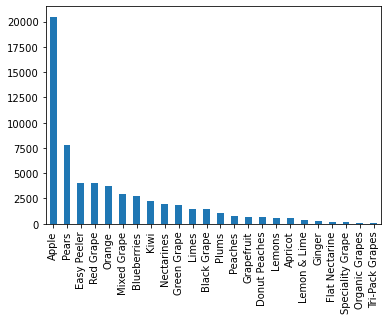

In [11]:
df.descr.value_counts().plot(kind='bar')

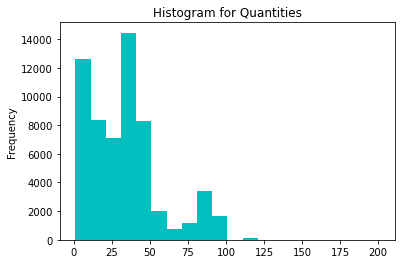

In [12]:
df.qty.plot(kind='hist', title='Histogram for Quantities', color='c', bins=20);

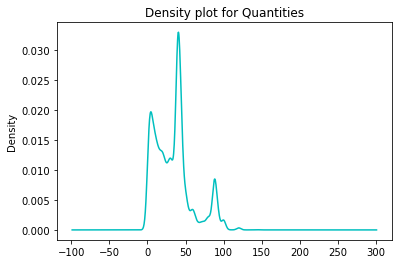

In [13]:
df.qty.plot(kind='kde', title='Density plot for Quantities', color='c');

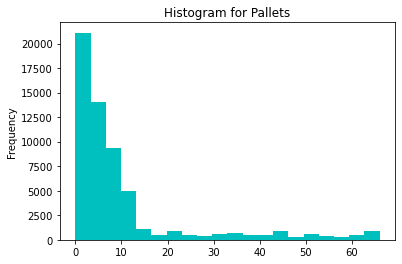

In [14]:
df.sodusseldorfs.plot(kind='hist', title='Histogram for Pallets', color='c', bins=20);

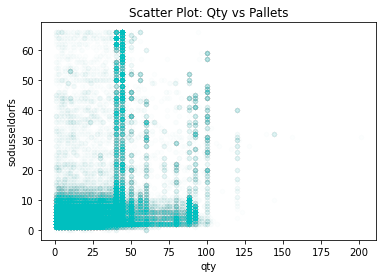

In [15]:
df.plot.scatter(x='qty', y='sodusseldorfs', color='c', title='Scatter Plot: Qty vs Pallets', alpha=0.01);

## Group and Aggregations

In [16]:
df.groupby(['descr', 'countsize']).qty.mean()

descr             countsize 
Apple             10x10 Pack    30.648740
                  10x4 OR       22.448331
                  10x4 SS       26.735234
                  10x4-Pack     17.249337
                  10x4pk RG     18.031348
                                  ...    
Red Grape         10X250G       74.529801
                  10x500g       66.311983
                  9x250g        71.038005
Speciality Grape  10X400G       27.550336
Tri-Pack Grapes   8x750g        36.397959
Name: qty, Length: 74, dtype: float64

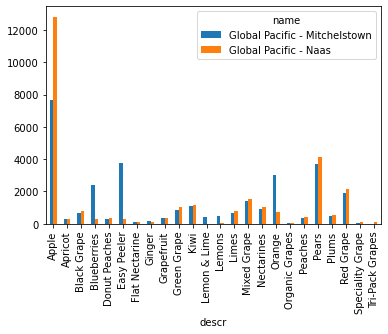

In [17]:
pd.crosstab(df.descr, df.name).plot(kind='bar');

## Data Munging

### Missing Values

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60094 entries, 2417225 to 2922075
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   palstkid       60094 non-null  int64  
 1   qty            60094 non-null  int64  
 2   orddetid       60094 non-null  int64  
 3   ponum          60093 non-null  float64
 4   ordnum         60094 non-null  int64  
 5   delcustcode    60094 non-null  object 
 6   deldate        60094 non-null  object 
 7   name           60094 non-null  object 
 8   prodnum        60093 non-null  float64
 9   jobnum         60083 non-null  float64
 10  mark           60094 non-null  object 
 11  descr          60094 non-null  object 
 12  countsize      60094 non-null  object 
 13  uomtradingqty  60094 non-null  float64
 14  sodusseldorfs  58681 non-null  float64
dtypes: float64(5), int64(4), object(6)
memory usage: 7.3+ MB


In [19]:
df[df.sodusseldorfs.isnull()]

,palstkid,qty,orddetid,ponum,ordnum,delcustcode,deldate,name,prodnum,jobnum,mark,descr,countsize,uomtradingqty,sodusseldorfs
palordid,,,,,,,,,,,,,,,
2418492,1494305,17,1402698,61574.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001240.0,112584.0,GP ALDI,Grapefruit,20,81.0,NaN
2418493,1494306,34,1402698,61574.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001240.0,112584.0,GP ALDI,Grapefruit,20,81.0,NaN
2418494,1496107,30,1402698,61574.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001240.0,112785.0,GP ALDI,Grapefruit,20,81.0,NaN
2437022,1508422,53,1412134,63783.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2000865.0,112804.0,GP ALDI,Easy Peeler,16x1kg,53.0,NaN
2492759,1537030,1,1447044,65622.0,79507,GLALM,2021-02-06 00:00:00,Global Pacific - Mitchelstown,2001308.0,116534.0,GP ALDI,Ginger,24x125g,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857399,1738117,88,1676104,75887.0,90837,GLALN,2021-08-18 00:00:00,Global Pacific - Naas,2000569.0,138441.0,GP Aldi Seedless,Red Grape,10x500g,295.0,NaN
2857389,1736706,4,1676103,75398.0,90837,GLALN,2021-08-18 00:00:00,Global Pacific - Naas,2000559.0,138548.0,GP Aldi,Green Grape,10x500g,186.0,NaN
2867190,1744359,36,1681278,74710.0,91161,GLALM,2021-08-24 00:00:00,Global Pacific - Mitchelstown,2001101.0,138927.0,GP ALDI,Apple,11x6-Pk PL,80.0,NaN


In [20]:
prodnum_qty_median = df.groupby(['prodnum', 'qty']).sodusseldorfs.transform('median')
df.sodusseldorfs.fillna(prodnum_qty_median, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60094 entries, 2417225 to 2922075
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   palstkid       60094 non-null  int64  
 1   qty            60094 non-null  int64  
 2   orddetid       60094 non-null  int64  
 3   ponum          60093 non-null  float64
 4   ordnum         60094 non-null  int64  
 5   delcustcode    60094 non-null  object 
 6   deldate        60094 non-null  object 
 7   name           60094 non-null  object 
 8   prodnum        60093 non-null  float64
 9   jobnum         60083 non-null  float64
 10  mark           60094 non-null  object 
 11  descr          60094 non-null  object 
 12  countsize      60094 non-null  object 
 13  uomtradingqty  60094 non-null  float64
 14  sodusseldorfs  60077 non-null  float64
dtypes: float64(5), int64(4), object(6)
memory usage: 7.3+ MB


In [22]:
qty_median = df.groupby('qty').sodusseldorfs.transform('median')
df.sodusseldorfs.fillna(qty_median, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60094 entries, 2417225 to 2922075
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   palstkid       60094 non-null  int64  
 1   qty            60094 non-null  int64  
 2   orddetid       60094 non-null  int64  
 3   ponum          60093 non-null  float64
 4   ordnum         60094 non-null  int64  
 5   delcustcode    60094 non-null  object 
 6   deldate        60094 non-null  object 
 7   name           60094 non-null  object 
 8   prodnum        60093 non-null  float64
 9   jobnum         60083 non-null  float64
 10  mark           60094 non-null  object 
 11  descr          60094 non-null  object 
 12  countsize      60094 non-null  object 
 13  uomtradingqty  60094 non-null  float64
 14  sodusseldorfs  60092 non-null  float64
dtypes: float64(5), int64(4), object(6)
memory usage: 7.3+ MB


## Outliers

In [24]:
df.loc[df.sodusseldorfs > 50].groupby('orddetid').sodusseldorfs.mean()

orddetid
1407256    62.0
1407276    66.0
1407277    62.0
1408117    62.0
1408129    66.0
           ... 
1679244    51.0
1683939    54.0
1685707    52.0
1686146    60.0
1686919    53.0
Name: sodusseldorfs, Length: 77, dtype: float64

## Packaging

In [25]:
packaging_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54001 entries, 1500298 to 1703955
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   actqty   54001 non-null  int64  
 1   prodnum  54001 non-null  int64  
 2   descr    54001 non-null  object 
 3   mark     54001 non-null  object 
 4   price    54001 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.5+ MB


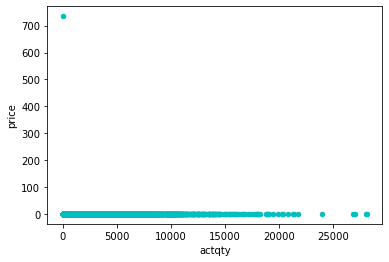

In [26]:
packaging_df.plot.scatter(x='actqty', y='price', color='c');

In [27]:
packaging_df[packaging_df.price > 700]

,actqty,prodnum,descr,mark,price
palstkid,,,,,
1329972,1,5000157,Flo wrap,560,735.0


<AxesSubplot:>

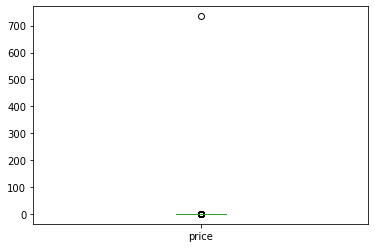

In [28]:
packaging_df.price.plot(kind='box')

In [29]:
packaging_df.groupby('prodnum').price.median()[5000157]

0.0462

In [30]:
packaging_df.loc[(packaging_df.actqty == 1) & (packaging_df.prodnum == 5000157), 'price'] = 0.0462

<AxesSubplot:>

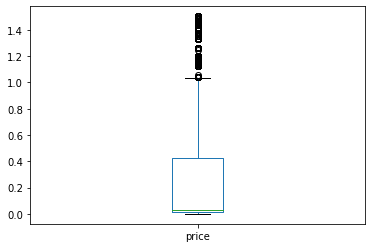

In [31]:
packaging_df.price.plot(kind='box')

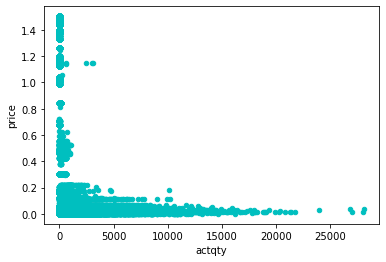

In [32]:
packaging_df.plot.scatter(x='actqty', y='price', color='c');

<AxesSubplot:ylabel='Frequency'>

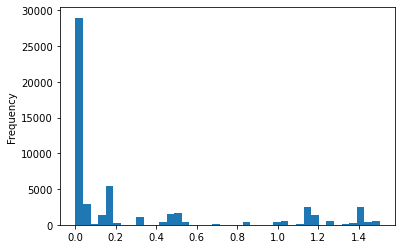

In [33]:
packaging_df.price.plot(kind='hist', bins=40)

<AxesSubplot:ylabel='Frequency'>

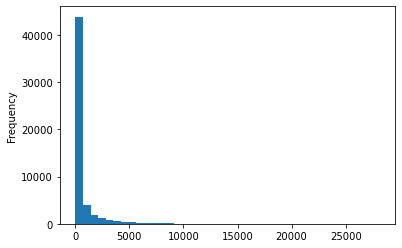

In [34]:
packaging_df.actqty.plot(kind='hist', bins=40)

<AxesSubplot:xlabel='descr', ylabel='price'>

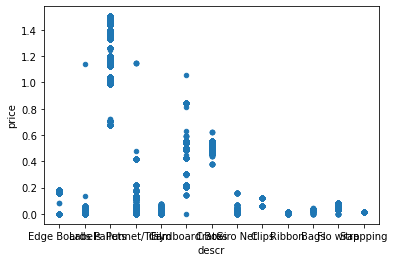

In [35]:
packaging_df.plot.scatter(x='descr', y='price')

<AxesSubplot:title={'center':'price'}, xlabel='descr'>

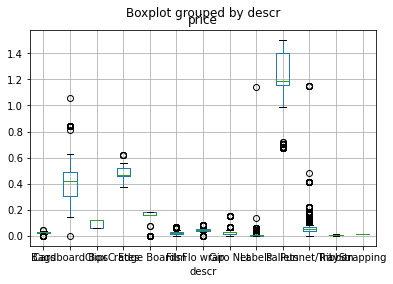

In [36]:
packaging_df.boxplot('price', 'descr')

## Finished

In [37]:
finished_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56295 entries, 1499022 to 1753991
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   palfilid       56295 non-null  int64  
 1   jobnum         56295 non-null  int64  
 2   recqty         56295 non-null  int64  
 3   weight         56295 non-null  float64
 4   prodnum        56295 non-null  int64  
 5   class          56295 non-null  int64  
 6   descr          56295 non-null  object 
 7   mark           56295 non-null  object 
 8   qtyouter       56295 non-null  int64  
 9   buildcatnum    56295 non-null  int64  
 10  reqdate        56295 non-null  object 
 11  buildcatdescr  56295 non-null  object 
 12  countsize      56295 non-null  object 
 13  freejob        894 non-null    object 
dtypes: float64(1), int64(7), object(6)
memory usage: 6.4+ MB


In [38]:
finished_df.groupby('descr').recqty.sum()

descr
Apple               514761
Apricot              17552
Black Grape          48876
Blueberries         131218
Donut Peaches        17567
Easy Peeler         130949
Flat Nectarine        3645
Ginger                8733
Grapefruit           20669
Green Grape          87909
Kiwi                 60732
Lemon & Lime          4165
Lemons               10929
Limes                54488
Mixed Grape         112793
Nectarines           43135
Orange              101908
Organic Grapes         800
Peaches              22668
Pears               215600
Plums                27044
Red Grape           265047
Speciality Grape      1920
Tri-Pack Grapes       1550
Name: recqty, dtype: int64

<AxesSubplot:xlabel='descr'>

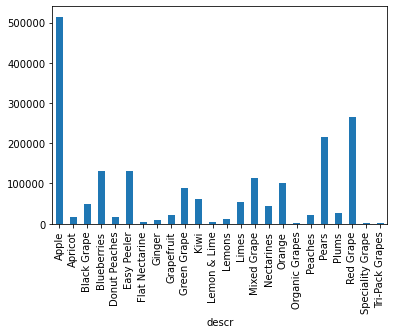

In [39]:
finished_df.groupby('descr').recqty.sum().plot(kind='bar')

In [40]:
finished_df.groupby(['descr', 'countsize']).recqty.sum()

descr             countsize 
Apple             10x10 Pack     56017
                  10x4 OR        11192
                  10x4 SS        25428
                  10x4-Pack       6520
                  10x4pk RG       5617
                                 ...  
Red Grape         10X250G        22396
                  10x500g       182963
                  9x250g         59688
Speciality Grape  10X400G         1920
Tri-Pack Grapes   8x750g          1550
Name: recqty, Length: 78, dtype: int64

<AxesSubplot:>

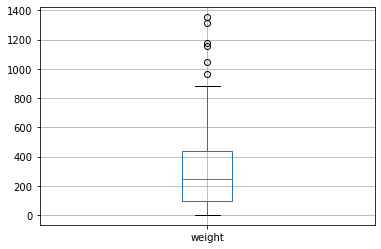

In [41]:
finished_df.boxplot('weight')

<AxesSubplot:xlabel='recqty', ylabel='weight'>

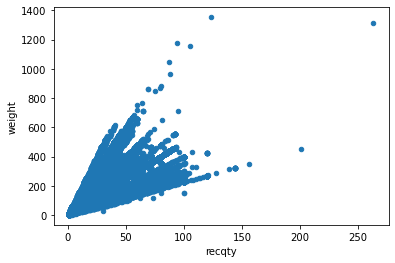

In [42]:
finished_df.plot.scatter(x='recqty', y='weight', alpha=1)

<AxesSubplot:xlabel='descr'>

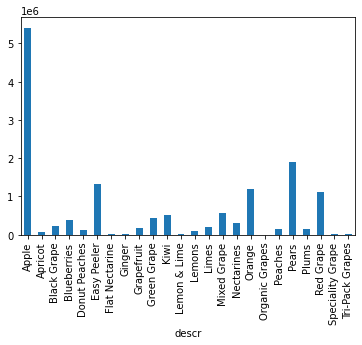

In [43]:
finished_df.groupby('descr').weight.sum().plot(kind='bar')

## Orders

In [44]:
descr_orders = df.groupby('descr').qty.sum().reset_index(name='ordersum')
print(descr_orders)

               descr  ordersum
0              Apple    555070
1            Apricot     16080
2        Black Grape     53507
3        Blueberries    139862
4      Donut Peaches     17615
5        Easy Peeler    128412
6     Flat Nectarine      3642
7             Ginger      8361
8         Grapefruit     20565
9        Green Grape    110929
10              Kiwi     67540
11      Lemon & Lime      5148
12            Lemons     13579
13             Limes     60468
14       Mixed Grape    122982
15        Nectarines     45570
16            Orange    101482
17    Organic Grapes      2649
18           Peaches     23668
19             Pears    226237
20             Plums     30093
21         Red Grape    274892
22  Speciality Grape      4105
23   Tri-Pack Grapes      3567


<AxesSubplot:>

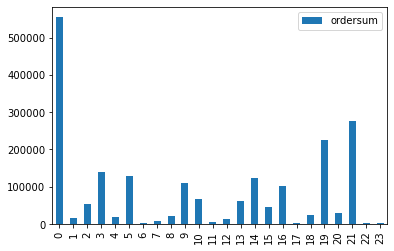

In [45]:
descr_orders.plot(kind='bar')

In [46]:
descr_finished = finished_df.groupby('descr').recqty.sum().reset_index(name='finished_cases')

def getFinishedCases(descr):
    return descr_finished.loc[lambda x: x['descr'] == descr].finished_cases.sum()

descr_orders['finished_cases'] = descr_orders.descr.map(lambda x: getFinishedCases(x))
descr_orders

,descr,ordersum,finished_cases
0,Apple,555070,514761
1,Apricot,16080,17552
2,Black Grape,53507,48876
3,Blueberries,139862,131218
4,Donut Peaches,17615,17567
5,Easy Peeler,128412,130949
6,Flat Nectarine,3642,3645
7,Ginger,8361,8733
8,Grapefruit,20565,20669
9,Green Grape,110929,87909


<AxesSubplot:>

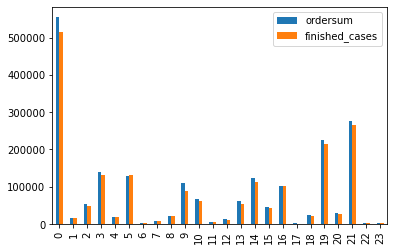

In [47]:
descr_orders.plot(kind='bar')

In [48]:
descr_orders['conversionper'] = ((descr_orders.finished_cases - descr_orders.ordersum)/descr_orders.finished_cases)*100
descr_orders

,descr,ordersum,finished_cases,conversionper
0,Apple,555070,514761,-7.830624
1,Apricot,16080,17552,8.386509
2,Black Grape,53507,48876,-9.474998
3,Blueberries,139862,131218,-6.587511
4,Donut Peaches,17615,17567,-0.273240
5,Easy Peeler,128412,130949,1.937395
6,Flat Nectarine,3642,3645,0.082305
7,Ginger,8361,8733,4.259705
8,Grapefruit,20565,20669,0.503169
9,Green Grape,110929,87909,-26.186170


<AxesSubplot:xlabel='descr'>

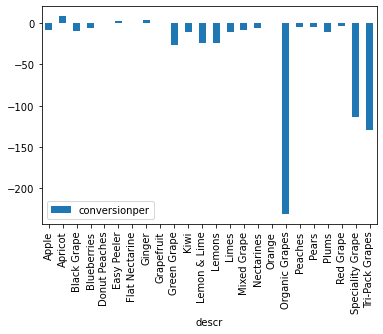

In [49]:
descr_orders.plot(kind='bar', x='descr', y='conversionper')

## Data Munging

In [50]:
ingredients_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23754 entries, 1671909 to 1751355
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   actqty     23754 non-null  int64  
 1   actweight  23754 non-null  float64
 2   prodnum    23754 non-null  int64  
 3   descr      23754 non-null  object 
 4   mark       23754 non-null  object 
 5   countsize  23754 non-null  object 
 6   ponum      23754 non-null  int64  
 7   palfilid   23754 non-null  int64  
 8   jobnum     23754 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 1.8+ MB


In [51]:
jobqtys = ingredients_df.groupby("jobnum").actqty.sum().reset_index(name="totaljobqty")
jobqtys

,jobnum,totaljobqty
0,112871,84
1,112876,126
2,112877,443
3,112878,140
4,112879,44
...,...,...
9691,140099,215
9692,140100,81
9693,140102,56
9694,140103,92


In [52]:
newjobqtys = {}

for i in jobqtys.index:
    newjobqtys[jobqtys['jobnum'][i]] = jobqtys['totaljobqty'][i]

ingredients_df['totalqtyin'] = ingredients_df.jobnum.map(newjobqtys)
ingredients_df

,actqty,actweight,prodnum,descr,mark,countsize,ponum,palfilid,jobnum,totalqtyin
palstkid,,,,,,,,,,
1671909,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108470,131944,281
1671910,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108471,131944,281
1671911,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108472,131556,98
1671912,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108473,131607,113
1671913,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108474,131944,281
...,...,...,...,...,...,...,...,...,...,...
1751345,32,208.0,2000338,Peaches,GP Aldi,13x4/5 Pk,76567,2203278,140040,32
1751349,92,552.0,2000554,Donut Peaches,GP Aldi,12x4-7 pcs,76570,2203282,140045,92
1751351,92,552.0,2001356,Donut Peaches,GP Raw Material,12x4-7pk,76572,2203284,139931,92


In [53]:
jobweights = ingredients_df.groupby("jobnum").actweight.sum().reset_index(name="totaljobweight")
jobweights

,jobnum,totaljobweight
0,112871,1050.0
1,112876,1638.0
2,112877,2436.5
3,112878,1820.0
4,112879,528.0
...,...,...
9691,140099,3870.0
9692,140100,1417.5
9693,140102,1008.0
9694,140103,552.0


In [54]:
newjobweights = {}

for i in jobweights.index:
    newjobweights[jobweights['jobnum'][i]] = jobweights['totaljobweight'][i]

ingredients_df['totalweightin'] = ingredients_df.jobnum.map(newjobweights)
ingredients_df

,actqty,actweight,prodnum,descr,mark,countsize,ponum,palfilid,jobnum,totalqtyin,totalweightin
palstkid,,,,,,,,,,,
1671909,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108470,131944,281,5058.0
1671910,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108471,131944,281,5058.0
1671911,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108472,131556,98,1764.0
1671912,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108473,131607,113,2034.0
1671913,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108474,131944,281,5058.0
...,...,...,...,...,...,...,...,...,...,...,...
1751345,32,208.0,2000338,Peaches,GP Aldi,13x4/5 Pk,76567,2203278,140040,32,208.0
1751349,92,552.0,2000554,Donut Peaches,GP Aldi,12x4-7 pcs,76570,2203282,140045,92,552.0
1751351,92,552.0,2001356,Donut Peaches,GP Raw Material,12x4-7pk,76572,2203284,139931,92,552.0


In [55]:
ingredients_df.loc[ingredients_df.jobnum == 131944]

,actqty,actweight,prodnum,descr,mark,countsize,ponum,palfilid,jobnum,totalqtyin,totalweightin
palstkid,,,,,,,,,,,
1671909,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108470,131944,281,5058.0
1671910,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108471,131944,281,5058.0
1671913,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108474,131944,281,5058.0
1671916,36,648.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108477,131944,281,5058.0
1671917,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108478,131944,281,5058.0
1671918,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108479,131944,281,5058.0


In [56]:
ingredients_df['pertotal'] = ingredients_df['actweight']/ingredients_df['totalweightin']
ingredients_df

,actqty,actweight,prodnum,descr,mark,countsize,ponum,palfilid,jobnum,totalqtyin,totalweightin,pertotal
palstkid,,,,,,,,,,,,
1671909,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108470,131944,281,5058.0,0.174377
1671910,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108471,131944,281,5058.0,0.174377
1671911,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108472,131556,98,1764.0,0.500000
1671912,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108473,131607,113,2034.0,0.433628
1671913,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108474,131944,281,5058.0,0.174377
...,...,...,...,...,...,...,...,...,...,...,...,...
1751345,32,208.0,2000338,Peaches,GP Aldi,13x4/5 Pk,76567,2203278,140040,32,208.0,1.000000
1751349,92,552.0,2000554,Donut Peaches,GP Aldi,12x4-7 pcs,76570,2203282,140045,92,552.0,1.000000
1751351,92,552.0,2001356,Donut Peaches,GP Raw Material,12x4-7pk,76572,2203284,139931,92,552.0,1.000000


In [57]:
finished_df

,palfilid,jobnum,recqty,weight,prodnum,class,descr,mark,qtyouter,buildcatnum,reqdate,buildcatdescr,countsize,freejob
palstkid,,,,,,,,,,,,,,
1499022,1900048,112931,2,21.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
1499026,1900052,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
1499012,1900333,112931,2,21.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
1499025,1900333,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
1499023,1900364,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753993,2205935,140075,92,460.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g,NaN
1753528,2206068,140075,73,365.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g,NaN
1753992,2206068,140075,92,460.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g,NaN


In [58]:
jobfinqtys = finished_df.groupby("jobnum").recqty.sum().reset_index(name="totaljobfinqty")

jobfinqtys = {jobfinqtys['jobnum'][i]:jobfinqtys['totaljobfinqty'][i] for i in jobfinqtys.index}
jobfinqtys

ingredients_df['totaljobqtyout'] = ingredients_df.jobnum.map(jobfinqtys)
ingredients_df

,actqty,actweight,prodnum,descr,mark,countsize,ponum,palfilid,jobnum,totalqtyin,totalweightin,pertotal,totaljobqtyout
palstkid,,,,,,,,,,,,,
1671909,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108470,131944,281,5058.0,0.174377,476
1671910,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108471,131944,281,5058.0,0.174377,476
1671911,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108472,131556,98,1764.0,0.500000,171
1671912,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108473,131607,113,2034.0,0.433628,191
1671913,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108474,131944,281,5058.0,0.174377,476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751345,32,208.0,2000338,Peaches,GP Aldi,13x4/5 Pk,76567,2203278,140040,32,208.0,1.000000,32
1751349,92,552.0,2000554,Donut Peaches,GP Aldi,12x4-7 pcs,76570,2203282,140045,92,552.0,1.000000,92
1751351,92,552.0,2001356,Donut Peaches,GP Raw Material,12x4-7pk,76572,2203284,139931,92,552.0,1.000000,92


In [59]:
finished_df

,palfilid,jobnum,recqty,weight,prodnum,class,descr,mark,qtyouter,buildcatnum,reqdate,buildcatdescr,countsize,freejob
palstkid,,,,,,,,,,,,,,
1499022,1900048,112931,2,21.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
1499026,1900052,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
1499012,1900333,112931,2,21.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
1499025,1900333,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
1499023,1900364,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753993,2205935,140075,92,460.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g,NaN
1753528,2206068,140075,73,365.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g,NaN
1753992,2206068,140075,92,460.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g,NaN


In [60]:
jobfinwghts = finished_df.groupby('jobnum').weight.sum().reset_index(name="totaljobfinweight")

jobfinwghts = {jobfinwghts['jobnum'][i]:jobfinwghts['totaljobfinweight'][i] for i in jobfinwghts.index}

ingredients_df['totaljobweightout'] = ingredients_df.jobnum.map(jobfinwghts)
ingredients_df

# jobfinqtys = finished_df.groupby("jobnum").recqty.sum().reset_index(name="totaljobfinqty")

# jobfinqtys = {jobfinqtys['jobnum'][i]:jobfinqtys['totaljobfinqty'][i] for i in jobfinqtys.index}
# jobfinqtys

# ingredients_df['totaljobqtyout'] = ingredients_df.jobnum.map(jobfinqtys)
# ingredients_df

,actqty,actweight,prodnum,descr,mark,countsize,ponum,palfilid,jobnum,totalqtyin,totalweightin,pertotal,totaljobqtyout,totaljobweightout
palstkid,,,,,,,,,,,,,,
1671909,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108470,131944,281,5058.0,0.174377,476,5236.0
1671910,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108471,131944,281,5058.0,0.174377,476,5236.0
1671911,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108472,131556,98,1764.0,0.500000,171,1881.0
1671912,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108473,131607,113,2034.0,0.433628,191,2101.0
1671913,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108474,131944,281,5058.0,0.174377,476,5236.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751345,32,208.0,2000338,Peaches,GP Aldi,13x4/5 Pk,76567,2203278,140040,32,208.0,1.000000,32,208.0
1751349,92,552.0,2000554,Donut Peaches,GP Aldi,12x4-7 pcs,76570,2203282,140045,92,552.0,1.000000,92,552.0
1751351,92,552.0,2001356,Donut Peaches,GP Raw Material,12x4-7pk,76572,2203284,139931,92,552.0,1.000000,92,552.0


In [61]:
jobqtys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9696 entries, 0 to 9695
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   jobnum       9696 non-null   int64
 1   totaljobqty  9696 non-null   int64
dtypes: int64(2)
memory usage: 151.6 KB


In [62]:
jobweights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9696 entries, 0 to 9695
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   jobnum          9696 non-null   int64  
 1   totaljobweight  9696 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 151.6 KB


In [63]:
jobqtys['totaljobweight'] = jobqtys.jobnum.map(newjobweights)
jobqtys['totalfinqty'] = jobqtys.jobnum.map(jobfinqtys)
jobqtys['totalfinwght'] = jobqtys.jobnum.map(jobfinwghts)
jobqtys['wghtdiff'] = jobqtys.totaljobweight - jobqtys.totalfinwght

<AxesSubplot:>

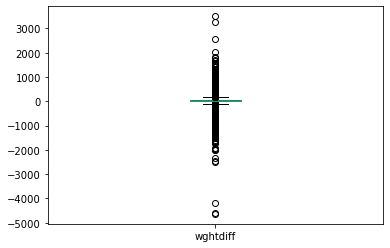

In [64]:
jobqtys.wghtdiff.plot(kind='box')

<AxesSubplot:ylabel='Frequency'>

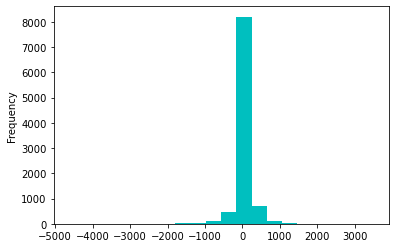

In [65]:
jobqtys.wghtdiff.plot(kind='hist', color='c', bins=20)

In [66]:
jobqtys[jobqtys.wghtdiff < -1000].sort_values(by=["jobnum"])

,jobnum,totaljobqty,totaljobweight,totalfinqty,totalfinwght,wghtdiff
147,113198,540,7020.0,946,8041.0,-1021.0
1097,115768,260,1560.0,260,2600.0,-1040.0
1329,116385,325,1950.0,325,3250.0,-1300.0
2260,118927,240,4320.0,546,5460.0,-1140.0
2278,118954,586,3516.0,586,5860.0,-2344.0
3362,121713,129,2322.0,371,3710.0,-1388.0
3584,122238,180,2340.0,357,4284.0,-1944.0
3663,122440,95,1235.0,188,2256.0,-1021.0
3907,123065,113,1469.0,222,2664.0,-1195.0
3998,123294,240,4320.0,577,5770.0,-1450.0


In [67]:
ingredients_df['weightoutcutoff'] = ingredients_df['pertotal'] * ingredients_df['totaljobweightout']
ingredients_df

,actqty,actweight,prodnum,descr,mark,countsize,ponum,palfilid,jobnum,totalqtyin,totalweightin,pertotal,totaljobqtyout,totaljobweightout,weightoutcutoff
palstkid,,,,,,,,,,,,,,,
1671909,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108470,131944,281,5058.0,0.174377,476,5236.0,913.039146
1671910,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108471,131944,281,5058.0,0.174377,476,5236.0,913.039146
1671911,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108472,131556,98,1764.0,0.500000,171,1881.0,940.500000
1671912,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108473,131607,113,2034.0,0.433628,191,2101.0,911.053097
1671913,49,882.0,2001216,Apple,GP Raw Material,18kg c113,72914,2108474,131944,281,5058.0,0.174377,476,5236.0,913.039146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751345,32,208.0,2000338,Peaches,GP Aldi,13x4/5 Pk,76567,2203278,140040,32,208.0,1.000000,32,208.0,208.000000
1751349,92,552.0,2000554,Donut Peaches,GP Aldi,12x4-7 pcs,76570,2203282,140045,92,552.0,1.000000,92,552.0,552.000000
1751351,92,552.0,2001356,Donut Peaches,GP Raw Material,12x4-7pk,76572,2203284,139931,92,552.0,1.000000,92,552.0,552.000000


In [68]:
finished_df = finished_df.drop(columns=['freejob'])

In [69]:
finished_df[finished_df.jobnum == 112871].sort_values(by=["jobnum"])

,palfilid,jobnum,recqty,weight,prodnum,class,descr,mark,qtyouter,buildcatnum,reqdate,buildcatdescr,countsize
palstkid,,,,,,,,,,,,,
1497551,1898431,112871,24,264.0,2001113,1,Apple,GP ALDI,11,3,2021-01-02 00:00:00,Packed from Loose,11x6 Kanzi
1497548,1900089,112871,38,418.0,2001113,1,Apple,GP ALDI,11,3,2021-01-02 00:00:00,Packed from Loose,11x6 Kanzi
1499324,1900379,112871,6,66.0,2001113,1,Apple,GP ALDI,11,3,2021-01-02 00:00:00,Packed from Loose,11x6 Kanzi
1497552,1901080,112871,8,88.0,2001113,1,Apple,GP ALDI,11,3,2021-01-02 00:00:00,Packed from Loose,11x6 Kanzi
1500726,1901080,112871,3,33.0,2001113,1,Apple,GP ALDI,11,3,2021-01-02 00:00:00,Packed from Loose,11x6 Kanzi
1501177,1903536,112871,13,143.0,2001113,1,Apple,GP ALDI,11,3,2021-01-02 00:00:00,Packed from Loose,11x6 Kanzi


In [70]:
ingredients_df[ingredients_df.jobnum == 112871].sort_values(by=["jobnum"])

,actqty,actweight,prodnum,descr,mark,countsize,ponum,palfilid,jobnum,totalqtyin,totalweightin,pertotal,totaljobqtyout,totaljobweightout,weightoutcutoff
palstkid,,,,,,,,,,,,,,,
1495035,24,300.0,2001208,Apple,GP Raw Material,12.5kg7075,64193,1895371,112871,84,1050.0,0.285714,92,1012.0,289.142857
1495036,60,750.0,2001208,Apple,GP Raw Material,12.5kg7075,64193,1895372,112871,84,1050.0,0.714286,92,1012.0,722.857143


In [71]:
df

,palstkid,qty,orddetid,ponum,ordnum,delcustcode,deldate,name,prodnum,jobnum,mark,descr,countsize,uomtradingqty,sodusseldorfs
palordid,,,,,,,,,,,,,,,
2417225,1497321,60,1393318,64117.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2000866.0,112869.0,GP ALDI,Easy Peeler,22x500g,113.0,6.0
2417340,1496082,40,1393334,62762.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001175.0,112746.0,GP ALDI,Pears,10x750g,113.0,6.0
2416814,1494310,48,1401546,64073.0,77374,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001186.0,112631.0,GP ALDI,Easy Peeler,10x750g EP,238.0,9.0
2417357,1494270,30,1393324,64100.0,76944,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2001230.0,112707.0,GP ALDI,Orange,10x4-Pack,110.0,6.0
2417384,1495900,88,1393339,63773.0,76950,GLALM,2021-01-01 00:00:00,Global Pacific - Mitchelstown,2000623.0,112730.0,GP ALDI,Black Grape,10x500g,128.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921788,1774355,3,1714459,74530.0,92646,GLALN,2021-09-22 00:00:00,Global Pacific - Naas,2001098.0,141898.0,GP ALDI,Apple,35,37.0,2.0
2922383,1772700,4,1714437,77440.0,92645,GLALN,2021-09-22 00:00:00,Global Pacific - Naas,2000562.0,142270.0,GP Aldi,Mixed Grape,10x500g,285.0,7.0
2919897,1774813,60,1714441,77149.0,92646,GLALN,2021-09-22 00:00:00,Global Pacific - Naas,2000339.0,142226.0,GP Aldi,Nectarines,13 x 4/5Pk,60.0,2.0


In [72]:
finished_df

,palfilid,jobnum,recqty,weight,prodnum,class,descr,mark,qtyouter,buildcatnum,reqdate,buildcatdescr,countsize
palstkid,,,,,,,,,,,,,
1499022,1900048,112931,2,21.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg
1499026,1900052,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg
1499012,1900333,112931,2,21.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg
1499025,1900333,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg
1499023,1900364,112931,40,420.0,2001173,1,Pears,GP ALDI,10,3,2021-01-02 00:00:00,Packed from Loose,10x1kg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753993,2205935,140075,92,460.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g
1753528,2206068,140075,73,365.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g
1753992,2206068,140075,92,460.0,2000569,1,Red Grape,GP Aldi Seedless,10,2,2021-09-01 00:00:00,Packed from Naked,10x500g


In [73]:
orderpalstkdates = {df['palstkid'][i]:df['deldate'][i] for i in df.index}
finisheddates = {finished_df['jobnum'][i]:finished_df['reqdate'][i] for i in finished_df.index}

finished_df['lastoutorderdate'] = finished_df.index.map(orderpalstkdates)
# finished_df['lastfinisheddate'] = finished_df.palfilid.map(finisheddates)
# finished_df
ingredients_df['reqdate'] = finished_df.jobnum.map(finisheddates)
finisheddates

{112931: '2021-01-02 00:00:00',
 112953: '2021-01-02 00:00:00',
 112954: '2021-01-02 00:00:00',
 113568: '2021-01-08 00:00:00',
 113825: '2021-01-12 00:00:00',
 113871: '2021-01-12 00:00:00',
 114244: '2021-01-15 00:00:00',
 112882: '2021-01-02 00:00:00',
 112891: '2021-01-02 00:00:00',
 112897: '2021-01-02 00:00:00',
 112907: '2021-01-02 00:00:00',
 112919: '2021-01-02 00:00:00',
 112917: '2021-01-02 00:00:00',
 112926: '2021-01-02 00:00:00',
 112929: '2021-01-02 00:00:00',
 112894: '2021-01-02 00:00:00',
 112895: '2021-01-02 00:00:00',
 112893: '2021-01-02 00:00:00',
 112904: '2021-01-02 00:00:00',
 112908: '2021-01-02 00:00:00',
 112921: '2021-01-02 00:00:00',
 112941: '2021-01-02 00:00:00',
 112923: '2021-01-02 00:00:00',
 112947: '2021-01-02 00:00:00',
 112951: '2021-01-02 00:00:00',
 112974: '2021-01-03 00:00:00',
 113000: '2021-01-04 00:00:00',
 113007: '2021-01-04 00:00:00',
 113013: '2021-01-04 00:00:00',
 113057: '2021-01-04 00:00:00',
 113012: '2021-01-04 00:00:00',
 113066:

In [74]:
finished_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56295 entries, 1499022 to 1753991
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   palfilid          56295 non-null  int64  
 1   jobnum            56295 non-null  int64  
 2   recqty            56295 non-null  int64  
 3   weight            56295 non-null  float64
 4   prodnum           56295 non-null  int64  
 5   class             56295 non-null  int64  
 6   descr             56295 non-null  object 
 7   mark              56295 non-null  object 
 8   qtyouter          56295 non-null  int64  
 9   buildcatnum       56295 non-null  int64  
 10  reqdate           56295 non-null  object 
 11  buildcatdescr     56295 non-null  object 
 12  countsize         56295 non-null  object 
 13  lastoutorderdate  55153 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 8.5+ MB
